In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

C:\Users\lukas.keller\Documents\DS\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\lukas.keller\Documents\DS\venv\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df = pd.read_csv('../train_ZoGVYWq.csv')
train_df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [3]:
get_indexes_where_urban = train_df[train_df['residence_area_type'] == 'Urban'].index.tolist()

renewals_where_res_urban = train_df.iloc[get_indexes_where_urban]['renewal']
renewals_where_res_urban.value_counts()

1    45183
0     3000
Name: renewal, dtype: int64

In [207]:
train_df.renewal.value_counts()

1    74855
0     4998
Name: renewal, dtype: int64

In [79]:
indexes_to_be_looked = train_df[train_df['application_underwriting_score'].isnull()].index.tolist()

premium_where_score_null = train_df.iloc[indexes_to_be_looked]['premium']
premium_where_score_null_list = premium_where_score_null.value_counts().index.tolist()

In [80]:
premium_means_dict = {}
for each_value in premium_where_score_null_list:
    test_rows = train_df[train_df['premium'] == each_value].index.tolist()
    premium_mean = train_df.iloc[test_rows]['application_underwriting_score'].mean()
    if not premium_means_dict.get(each_value):
        premium_means_dict[each_value] = premium_mean
    else:
        print ('Some thing is wrong')
    

In [81]:
def fill_null_values(row):
    if row.isnull()['application_underwriting_score']:
        return premium_means_dict[row['premium']]
    else:
        return row['application_underwriting_score']

In [82]:
train_df['application_underwriting_score'] = train_df.apply(fill_null_values,axis=1)

In [83]:
train_df['income/premium'] = train_df['premium'] / train_df['Income']
train_df['age_in_years'] = train_df['age_in_days'] / 365
train_df.drop(['age_in_days'],axis=1,inplace=True)

In [84]:
train_df.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal,income/premium,age_in_years
0,110936,0.429,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,0.009294,33.035616
1,41492,0.010,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,0.057116,59.030137
2,31300,0.917,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,0.039220,48.030137
3,19415,0.049,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,0.038322,42.030137
4,99379,0.052,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,0.048319,86.027397


In [85]:
dtrain= pd.get_dummies(train_df)
train = dtrain
target = 'renewal'
IDcol = 'id'

In [86]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['renewal'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['renewal'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['renewal'], dtrain_predprob))
                    
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9443
AUC Score (Train): 0.863798


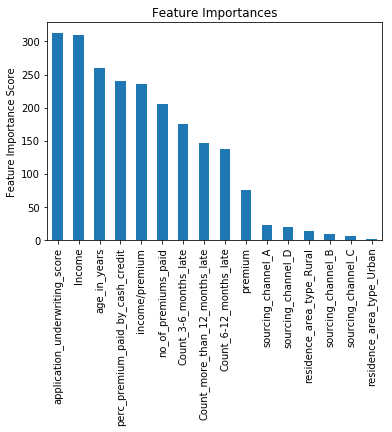

In [87]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [110]:
param_test1 = { 'max_depth':list(range(3,10,2)), 'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


([mean: 0.84238, std: 0.00469, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.84220, std: 0.00446, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.84234, std: 0.00444, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84087, std: 0.00514, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84125, std: 0.00468, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84198, std: 0.00468, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83656, std: 0.00422, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83629, std: 0.00423, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83679, std: 0.00447, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82964, std: 0.00423, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83157, std: 0.00464, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83184, std: 0.00543, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [111]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84149, std: 0.00458, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.84160, std: 0.00456, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.84170, std: 0.00435, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.84238, std: 0.00469, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.84224, std: 0.00447, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.84244, std: 0.00453, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.84235, std: 0.00445, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.84172, std: 0.00461, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.84225, std: 0.00408, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 3, 'min_child_weight': 4},
 0.8424362330268282)

In [15]:
param_test2b = {
 'min_child_weight':[5,7,9,11]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [5, 7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [16]:
# modelfit(gsearch3.best_estimator_, train, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.84231, std: 0.00479, params: {'min_child_weight': 5},
  mean: 0.84244, std: 0.00461, params: {'min_child_weight': 7},
  mean: 0.84224, std: 0.00485, params: {'min_child_weight': 9},
  mean: 0.84239, std: 0.00502, params: {'min_child_weight': 11}],
 {'min_child_weight': 7},
 0.8424372636546773)

In [112]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84244, std: 0.00453, params: {'gamma': 0.0},
  mean: 0.84245, std: 0.00455, params: {'gamma': 0.1},
  mean: 0.84248, std: 0.00456, params: {'gamma': 0.2},
  mean: 0.84248, std: 0.00456, params: {'gamma': 0.3},
  mean: 0.84248, std: 0.00456, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.8424782289068844)

C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9412
AUC Score (Train): 0.851899


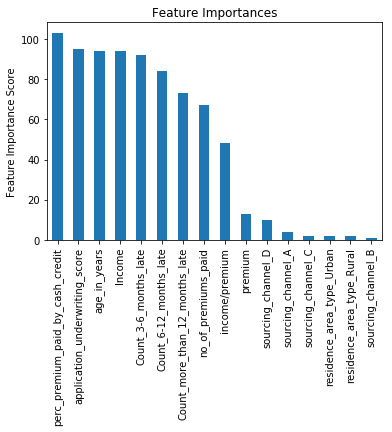

In [113]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [114]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.84226, std: 0.00458, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.84219, std: 0.00448, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.84213, std: 0.00453, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.84224, std: 0.00431, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.84230, std: 0.00441, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.84218, std: 0.00434, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.84241, std: 0.00418, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.84213, std: 0.00440, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.84272, std: 0.00414, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.84228, std: 0.00412, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.84245, std: 0.00455, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.84207, std: 0.00413, params: {'colsample_bytree': 0.8, 'subsample'

In [115]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84215, std: 0.00417, params: {'colsample_bytree': 0.75, 'subsample': 0.55},
  mean: 0.84250, std: 0.00429, params: {'colsample_bytree': 0.75, 'subsample': 0.6},
  mean: 0.84226, std: 0.00430, params: {'colsample_bytree': 0.75, 'subsample': 0.65},
  mean: 0.84195, std: 0.00432, params: {'colsample_bytree': 0.8, 'subsample': 0.55},
  mean: 0.84272, std: 0.00414, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.84245, std: 0.00446, params: {'colsample_bytree': 0.8, 'subsample': 0.65},
  mean: 0.84240, std: 0.00409, params: {'colsample_bytree': 0.85, 'subsample': 0.55},
  mean: 0.84258, std: 0.00394, params: {'colsample_bytree': 0.85, 'subsample': 0.6},
  mean: 0.84264, std: 0.00462, params: {'colsample_bytree': 0.85, 'subsample': 0.65}],
 {'colsample_bytree': 0.8, 'subsample': 0.6},
 0.8427226478097897)

In [116]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=4, gamma=0.4, subsample=0.6, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.84271, std: 0.00413, params: {'reg_alpha': 1e-05},
  mean: 0.84259, std: 0.00433, params: {'reg_alpha': 0.01},
  mean: 0.84284, std: 0.00462, params: {'reg_alpha': 0.1},
  mean: 0.84260, std: 0.00424, params: {'reg_alpha': 1},
  mean: 0.84062, std: 0.00466, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.8428395415587921)

In [117]:
param_test7 = {
 'reg_alpha':[0.05,0.01,0.5,0.1,0]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=4, gamma=0.4, subsample=0.6, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.84247, std: 0.00427, params: {'reg_alpha': 0.05},
  mean: 0.84259, std: 0.00433, params: {'reg_alpha': 0.01},
  mean: 0.84234, std: 0.00427, params: {'reg_alpha': 0.5},
  mean: 0.84284, std: 0.00462, params: {'reg_alpha': 0.1},
  mean: 0.84272, std: 0.00414, params: {'reg_alpha': 0}],
 {'reg_alpha': 0.1},
 0.8428395415587921)

C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.941
AUC Score (Train): 0.850558


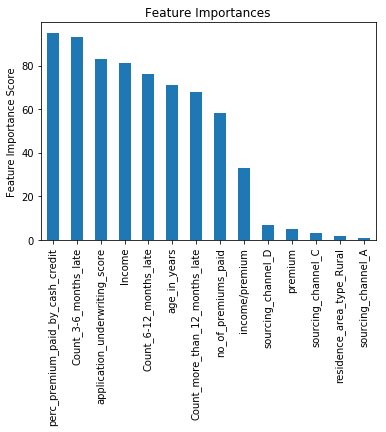

In [119]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0.4,
 subsample=0.6,
 colsample_bytree=0.8,
 reg_alpha=0.1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9411
AUC Score (Train): 0.851024


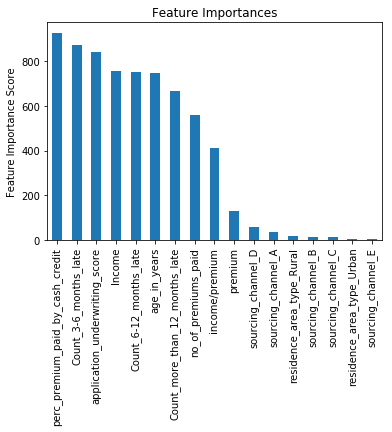

In [120]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=4,
 gamma=0.4,
 subsample=0.6,
 colsample_bytree=0.8,
 reg_alpha=0.1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [121]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [122]:
indexes_to_be_looked = df_test[df_test['application_underwriting_score'].isnull()].index.tolist()

premium_where_score_null = df_test.iloc[indexes_to_be_looked]['premium']
premium_where_score_null_list = premium_where_score_null.value_counts().index.tolist()

In [123]:
premium_means_dict = {}
for each_value in premium_where_score_null_list:
    test_rows = df_test[df_test['premium'] == each_value].index.tolist()
    premium_mean = df_test.iloc[test_rows]['application_underwriting_score'].mean()
    if not premium_means_dict.get(each_value):
        premium_means_dict[each_value] = premium_mean
    else:
        print ('Some thing is wrong')

In [124]:
def fill_null_values(row):
    if row.isnull()['application_underwriting_score']:
        return premium_means_dict[row['premium']]
    else:
        return row['application_underwriting_score']

In [125]:
df_test['application_underwriting_score'] = df_test.apply(fill_null_values,axis=1)

In [126]:
df_test['income/premium'] = df_test['premium'] / df_test['Income']
df_test['age_in_years'] = df_test['age_in_days'] / 365
df_test.drop(['age_in_days'],axis=1,inplace=True)


In [127]:
dtest= pd.get_dummies(df_test)

In [128]:
test_id = dtest.id
dtest.drop(['id'],axis=1,inplace=True)

In [129]:
xgb4.fit(dtrain[predictors], dtrain['renewal'],eval_metric='auc')
preds_renewals = xgb4.predict(dtest)
pred_prob_renewals = xgb4.predict_proba(dtest)

C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [150]:
def get_percentage_for_incentives(row):
    return 0.04
#     if row['age_of_person'] <= 40:
#         if row['renewal_probability'] >= 0.80:
#             return 0.03
#         elif row['renewal_probability'] >= 0.50 and row['renewal_probability'] < 0.8:
#             return 0.04
#         else:
#             return 0.05
#     elif row['age_of_person'] >= 40 and row['age_of_person'] < 50:
#         if row['renewal_probability'] >= 0.80:
#             return 0.02
#         elif row['renewal_probability'] >= 0.50 and row['renewal_probability'] < 0.8:
#             return 0.03
#         else:
#             return 0.04
#     elif row['age_of_person'] >= 50 and row['age_of_person'] < 60:
#         if row['renewal_probability'] >= 0.80:
#             return 0.01
#         elif row['renewal_probability'] >= 0.50 and row['renewal_probability'] < 0.8:
#             return 0.02
#         else:
#             return 0.03
#     elif row['age_of_person'] >= 60 :
#         if row['renewal_probability'] >= 0.80:
#             return 0.005
#         elif row['renewal_probability'] >= 0.50 and row['renewal_probability'] < 0.8:
#             return 0.001
#         else:
#             return 0.01

In [170]:
def get_percentage_for_incentives(row):
    
    if row['renewal_probability'] >= 0.80:
        return 0.02
    elif row['renewal_probability'] >= 0.50:
        return 0.03
    else:
        return 0.04

In [135]:
def get_percentage_for_incentives(row):
    if row['age_of_person'] >= 50:
        return 0.03
    elif row['age_of_person'] < 50:
        return 0.04

In [72]:
def get_percentage_for_incentives(row):
#     return 0.03
    if row['age_of_person'] <= 40:
        if row['renewal_probability'] >= 0.50:
            return 0.04
        else:
            return 0.06
    elif row['age_of_person'] >= 40 and row['age_of_person'] < 50:
        if row['renewal_probability'] >= 0.50:
            return 0.04
        else:
            return 0.05
    elif row['age_of_person'] >= 50 and row['age_of_person'] < 60:
        if row['renewal_probability'] >= 0.50:
            return 0.03
        else:
            return 0.04
    elif row['age_of_person'] >= 60 :
        if row['renewal_probability'] >= 0.50:
            return 0.025
        else:
            return 0.03

In [171]:
test_premium = dtest['premium']
age_of_person = dtest['age_in_years']
renewal_probability = pd.Series(pred_prob_renewals[:,1])
incentives_df = pd.DataFrame({'premium':test_premium,'renewal_probability':renewal_probability,
                              'age_of_person':age_of_person})

percentage_on_premium_for_incentives = incentives_df.apply(get_percentage_for_incentives,axis=1)
incentives = test_premium.multiply(percentage_on_premium_for_incentives)

In [172]:
sub = pd.DataFrame({'id': test_id,'renewal':renewal_probability,'incentives':incentives})

In [173]:
# sub.loc[sub['renewal'] >= 0.5, 'incentives'] = 0
sub.head()

,id,incentives,renewal
0,649,66.0,0.991429
1,81136,234.0,0.985653
2,70762,234.0,0.899684
3,53935,108.0,0.975956
4,15476,192.0,0.959132


In [174]:
sub.to_csv(path_or_buf='result_latest.csv',sep=',',index=False,header=True,columns=['id','renewal','incentives'])